# Classificador RPG IA

https://course.spacy.io/en/

# 1 - Entendimento do negócio
# Contexto
Se der, montem um git para compartilharmos código, pode ser pessoal mesmo...
São 3 arquivos distintos na massa de dados.
As duas informações importantes em casa arquivo são o skill que o mestre julgou necessário e qual frase (texto) o mestre avaliou para pedir o skill check.
Se conseguirem para sexta:
- empilhem os dados em um único arquivo
- vamos fazer uma análise de quantas frases temos por skill

Se conseguirem pensar me mais coisas, podem ir adiantando... vamos fazer tratamento de NLP, então se quiserem estudar um pouco o assunto, sempre é útil

# Sites úteis
Os arquivos tb estão aqui:

self.CR_url = 'https://raw.githubusercontent.com/amiapmorais/datasets/master/critical_role/skills_dataset.csv'

self.SS_url = 'https://raw.githubusercontent.com/amiapmorais/datasets/master/skill_db.csv'

self.GP_url = 'https://raw.githubusercontent.com/amiapmorais/datasets/master/podcasts/general_podcasts.csv'

Não tenho certeza que são exatamente os mesmos do zip, mas devem ser muito próximos se não forem iguais.


# Obs
Se for uma rede neural vc usa transfer learning. Que se baseia em espaço vetorial.
O que vamos aprender é bem mais simples, usamos uma coisa chamada TF / DF, que é Term Frequency e Document Frequency. Basicamente contamos as vezes que uma palavra aparece no total e depois contamos quantas vezes ela aparece em cada documento. A proporção entre esses dois números é suficiente em muitos casos para separar o que queremos...
Vamos começar com isso e depois sofisticar um pouco... quem sabe até montar uma rede neural primitiva....

TO DOs:
- Usando pandas
- Listar os skills distintos em uma lista
- Iterar a lista de skills e criar um slice do corpus com o filtro por skill
- para cada slice do corpus gerar o gráfico de barras e a wordcloud

# Proposta

![ideia](ideia.png)

# 2 - Entendimento dos dados
## 2.1- Leitura dos dados
### Descrição das bases fornecidas
São fontes de dados distintas.

* CR - Critical Role um podcast de RPG

* SS - Skill Store, uma planilha que criamos com exemplos

* GP - General Podcasts, scrappings que fizemos


In [1]:
# Abrindo conexão com o Google Drive.

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [188]:
# Importando bibliotecas.
import pandas as pd
import numpy as np

import re
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')
nltk.download('punkt')
import spacy
nlp = spacy.load("en_core_web_sm")

# Vectorizer for dictionary
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
# Verificando a acuracia.
from sklearn.metrics import confusion_matrix
from sklearn import metrics

import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud

#Apresentas os dados no notebook.
%matplotlib inline 

# Tamanho da imagem.
plt.rcParams['figure.figsize'] = (12,8)

# Parametros do Pandas, limitando a quantidade máxima e a largura das colunas.
pd.set_option('max_columns', 120)
pd.set_option('max_colwidth', 5000)

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\rafhael.martins\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\rafhael.martins\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


### 2.1.1 - Dicionário de dados - Fonte Critical Role (CR)

Coluna | Descricao
------ | ----------
skill | Nome da habilidade
backward_text | Texto referente a habilidade
check_line | Verificação da habilidade

In [2]:
# Lendo o dataset CR_skills_dataset.
df_cr = pd.read_csv("CR_skills_dataset.csv")

# Proporção do dataset.
df_cr.shape

(5254, 3)

In [3]:
# Verificando a estrutura.
df_cr.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5254 entries, 0 to 5253
Data columns (total 3 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   skill          5254 non-null   object
 1   backward_text  5254 non-null   object
 2   check_line     5254 non-null   object
dtypes: object(3)
memory usage: 123.3+ KB


In [4]:
# Primeiros dados.
df_cr.head(1)

,skill,backward_text,check_line
0,Persuasion,"‘Cause the dwarves weren't fans of nobody without any political means of entry. However she managed to acquire the necessary documentation and offered you a very substantial reward should you find the whereabouts of Lady Kima of Vord and hopefully bring her back safely. You left on the pathway to the dwarven citadel of Kraghammer. You were ambushed by a group of roaming barbarian Goliaths. Of which, partway through the battle, Grog managed to recognize one of them as a previous ally. And no longer an ally at this time. Son of a bitch. Yep, the Barbarian for his first and only time so far managed to avert battle through a social encounter",and rolled pretty damn well on a persuasion check.


In [5]:
# Últimos dados.
df_cr.tail(1)

,skill,backward_text,check_line
5253,Perception,"clean up. When Fjord's taking a bath, I'm going to go through his stuff and try to find his letter. His letter? The letter for the Solstryce Academy. Okay. Go ahead and make a stealth check. Not good. 15. 15? Would you have taken your stuff in with you? Or would I still be in the room? Molly would probably still be in the room. I got to stealth past Molly, or get him out of the room.","MATT: You do. Make a perception check, Molly."


### 2.1.2 - Dicionário de dados - Fonte General Podcasts (GP)

Coluna | Descricao
------ | ----------
skill | Nome da habilidade
backward_text | Texto referente a habilidade
check_line | Verificação da habilidade
original_name | Nome original da habilidade

In [6]:
# Lendo o dataset general_podcasts.
df_gp = pd.read_csv("general_podcasts.csv")

# Proporção do dataset.
df_gp.shape

(1733, 4)

In [7]:
# Verificando a estrutura.
df_gp.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1733 entries, 0 to 1732
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   skill          1733 non-null   object
 1   backward_text  1733 non-null   object
 2   check_line     1733 non-null   object
 3   original_name  1733 non-null   object
dtypes: object(4)
memory usage: 54.3+ KB


In [8]:
# Primeiros dados.
df_gp.head(1)

,skill,backward_text,check_line,original_name
0,Perception,"going weekly for the rest of the experimental arcs [ Woohoo!] starting this week. So, um, I guess actually we have an episode— I hope we don’t screw it up!","Yeah, no, me too. I don’t know why you would even say that. Um, so, let’s get started! Monster of the Week is a game sort of modeled after, appropriately enough, like, monster-of-the-week shows like, uh, Buffy and Supernatural. In which, in each sort of arc, there is a monster that a team of hunters has to hunt down. It is a game that is part of the Powered by the Apocalypse system which, if you listen to the Balance arc, is sort of what I based the Stolen Century episodes on. It is a very— it’s sort of like the d20 system, right? That covers a lot of different games, like D&D and Pathfinder. Uh, it is sort of just like a broad rule set that you can put a bunch of different stuff on top of to make it fit whatever genre you want it to fit. And there’s a ton of very cool games that use the Powered by the Apocalypse system. Uh, I was inspired to do an Apocalypse game because of one of my favorite podcasts, Friends at the Table, which has done a bunch of really cool ones in sci-fi worlds and fantasy worlds and all kinds of stuff. But Monster of the Week is sort of this, this monster-of-the-week sort of horror but like, campy horror? Uh, thing that’s going on here? And the basic rule that covers pretty much everything in Monster of the Week and all the Apocalypse games, is that whenever something comes up that is not, like, an automatic thing, like is something that is dangerous or a conflict, or something that would be covered by like a D&D move, like, oh, you have to roll a perception check if you wanna actually notice that thing, all that stuff is in here, but instead of rolling a 20-sided dice, you roll two six-sided dice, and then one of three things happens. Either you roll a six or below, and you have fucked up. You have fucked up now. And something goes horribly wrong sort of at my discretion. I’ll be GMing this game, they actually call the GM in this game The Keeper which is, like, so great to me? That the fiction of the game extends out of the game, like, Stranger Things style. So, six or below is a miss. A seven to nine is a mixed success, where you get to do the thing you wanna do, but usually there is a cost. And then a 10 plus is “You crushed it,” and you get to do what you wanna do, and usually it’s just all great.",Perception


In [9]:
# Últimos dados.
df_gp.tail(1)

,skill,backward_text,check_line,original_name
1732,Athletics,"vengeful spirit somehow finding you all the way out here, remains within the boundary of the forest. And what item do you find as you are making your escape? Paulomi","You mentioned that if there are people, they’re not going to make it. [laughs] But, I really like the idea of basically colliding, just headlong, into another person. Probably a straggler from that research camp that I was nearby earlier. And I think we both, like, go rolling for a second. And I jump up very quickly and kind of draw the pistol that I have tucked away in my belt. And I’m just like",Jump


### 2.1.3 - Dicionário de dados - Fonte Skill Store (SS)

Coluna | Descricao
------ | ----------
skill | Nome da habilidade
backward_text | Texto referente a habilidade
original_name | Nome original da habilidade

In [10]:
# Lendo o dataset skills_dataset.
df_ss = pd.read_csv("skills_dataset.csv")

# Proporção do dataset.
df_ss.shape

(49805, 3)

In [11]:
# Verificando a estrutura.
df_ss.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 49805 entries, 0 to 49804
Data columns (total 3 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   skill          49805 non-null  object
 1   backward_text  49805 non-null  object
 2   original_name  49650 non-null  object
dtypes: object(3)
memory usage: 1.1+ MB


In [12]:
# Primeiros dados.
df_ss.head(1)

,skill,backward_text,original_name
0,History,"> nodded accepting the parcel by ’s hands, in meantime he searched his memory to find out whether this axe had any worth beyond the iron which it was made of, or if it was mentioned in any song that was sung along the Anduin valleys. In fact it seemed weird to him that the hermit took so much care of it crazy as it was.",Lore


In [13]:
# Últimos dados.
df_ss.tail(1)

,skill,backward_text,original_name
49804,Stealth,"@ Milo: The sounds of movement far off in the distance alerts you. It is something that moves quickly, rustling forest floor leaves, sticks crack and thumping the earth. (gain an advancement pt) @ : (Stealth)You have strayed some distance from the hunting party of woodmen and the other beorning, but you see a fire light flicker in the distance and approaching, you are able to get close enough to see two little hobbits about their small fire - doesnt even notice you! (gain an advancement pt)(Awareness) You now feel the presence that someone else is here, hidden by the darkness. Perhaps you saw a dark shape or heard their breathing. (gain an advancement pt)(OOC - I should have make a Stealth check to have been hidden, however a failure will defeat my desired purpose for his initial meeting, so for now, he remains unseen though feels his presence)",Stealth


### 2.1.4 - Concat para união dos datasets

In [14]:
# Concatenado os datasets em um único dataset.
df = pd.concat([df_cr, df_gp, df_ss], ignore_index=True)

# Proporção do dataset.
df.shape

(56792, 4)

In [15]:
# Primeiros dados.
df.head(1)

,skill,backward_text,check_line,original_name
0,Persuasion,"‘Cause the dwarves weren't fans of nobody without any political means of entry. However she managed to acquire the necessary documentation and offered you a very substantial reward should you find the whereabouts of Lady Kima of Vord and hopefully bring her back safely. You left on the pathway to the dwarven citadel of Kraghammer. You were ambushed by a group of roaming barbarian Goliaths. Of which, partway through the battle, Grog managed to recognize one of them as a previous ally. And no longer an ally at this time. Son of a bitch. Yep, the Barbarian for his first and only time so far managed to avert battle through a social encounter",and rolled pretty damn well on a persuasion check.,NaN


In [16]:
# Selecionando colunas
df = df[["skill", "backward_text"]]

# Primeiros dados
df.head()

,skill,backward_text
0,Persuasion,"‘Cause the dwarves weren't fans of nobody without any political means of entry. However she managed to acquire the necessary documentation and offered you a very substantial reward should you find the whereabouts of Lady Kima of Vord and hopefully bring her back safely. You left on the pathway to the dwarven citadel of Kraghammer. You were ambushed by a group of roaming barbarian Goliaths. Of which, partway through the battle, Grog managed to recognize one of them as a previous ally. And no longer an ally at this time. Son of a bitch. Yep, the Barbarian for his first and only time so far managed to avert battle through a social encounter"
1,Persuasion,"Careful. (sighs) Not as often as I get woken up from my sleep. Which is never. Because only stupid people do that. Lost cause. Abandon ship, abandon ship! Right. I have an intelligence of six, I know what I'm doing. Okay. (all laugh) There is a very pretty lady over there, with slightly pointy ears - (to Vex) I'm talking about you - (to Keyleth) or you - There's two of them! And they were actually wanting to ask you a question if you wouldn't mind."
2,Persuasion,"You're so… we just heard you're so… impressive and masculine. Yes! We really wanted to talk to you. I use my Earring of Whisper to Vex. Cool it, cool it down. Oh sh- okay. Calm down. Not so sexy. I reach out and I stroke his bicep. Oh, Jesus. Because I can't hear that. I use it again, I'm like - What are you doing? Keyleth, stop it. I disagree, heat it up, heat it up."
3,Persuasion,"they're terrible people. Anyway, my associates and I were wondering if you might come - Is that what we're doing? Trying to get him to come with us? We're trying to find out more about Greyspine. Yes! Where he might be or who his associates might be. Gee, I'm so glad you came. Would you like to accompany us on this journey that we're taking? Oh god. We're trying to find the Greyspines and you seem like you would want to come in on this. We think there might be something rotten in the mines."
4,Persuasion,"Anyway, my associates and I were wondering if you might come - Is that what we're doing? Trying to get him to come with us? We're trying to find out more about Greyspine. Yes! Where he might be or who his associates might be. Gee, I'm so glad you came. Would you like to accompany us on this journey that we're taking? Oh god. We're trying to find the Greyspines and you seem like you would want to come in on this. We think there might be something rotten in the mines. Make a persuasion roll. You can assist if you like."


## 2.2 - Verificando os dados

In [17]:
# Proporção do dataset.
df.shape

(56792, 2)

In [18]:
# Verificando a estrutura.
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 56792 entries, 0 to 56791
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   skill          56792 non-null  object
 1   backward_text  56792 non-null  object
dtypes: object(2)
memory usage: 887.5+ KB


In [19]:
# Priemeiros dados.
df.head()

,skill,backward_text
0,Persuasion,"‘Cause the dwarves weren't fans of nobody without any political means of entry. However she managed to acquire the necessary documentation and offered you a very substantial reward should you find the whereabouts of Lady Kima of Vord and hopefully bring her back safely. You left on the pathway to the dwarven citadel of Kraghammer. You were ambushed by a group of roaming barbarian Goliaths. Of which, partway through the battle, Grog managed to recognize one of them as a previous ally. And no longer an ally at this time. Son of a bitch. Yep, the Barbarian for his first and only time so far managed to avert battle through a social encounter"
1,Persuasion,"Careful. (sighs) Not as often as I get woken up from my sleep. Which is never. Because only stupid people do that. Lost cause. Abandon ship, abandon ship! Right. I have an intelligence of six, I know what I'm doing. Okay. (all laugh) There is a very pretty lady over there, with slightly pointy ears - (to Vex) I'm talking about you - (to Keyleth) or you - There's two of them! And they were actually wanting to ask you a question if you wouldn't mind."
2,Persuasion,"You're so… we just heard you're so… impressive and masculine. Yes! We really wanted to talk to you. I use my Earring of Whisper to Vex. Cool it, cool it down. Oh sh- okay. Calm down. Not so sexy. I reach out and I stroke his bicep. Oh, Jesus. Because I can't hear that. I use it again, I'm like - What are you doing? Keyleth, stop it. I disagree, heat it up, heat it up."
3,Persuasion,"they're terrible people. Anyway, my associates and I were wondering if you might come - Is that what we're doing? Trying to get him to come with us? We're trying to find out more about Greyspine. Yes! Where he might be or who his associates might be. Gee, I'm so glad you came. Would you like to accompany us on this journey that we're taking? Oh god. We're trying to find the Greyspines and you seem like you would want to come in on this. We think there might be something rotten in the mines."
4,Persuasion,"Anyway, my associates and I were wondering if you might come - Is that what we're doing? Trying to get him to come with us? We're trying to find out more about Greyspine. Yes! Where he might be or who his associates might be. Gee, I'm so glad you came. Would you like to accompany us on this journey that we're taking? Oh god. We're trying to find the Greyspines and you seem like you would want to come in on this. We think there might be something rotten in the mines. Make a persuasion roll. You can assist if you like."


In [20]:
# Últimos dados.
df.tail()

,skill,backward_text
56787,Survival,"The great beast leaps through the camp, pierced by arrow and struck by axe. It continues, undaunted by its wounds yet you know it wont see the morning sun. It returns to the darkness of the woods with a spring before you notice it stumble a little in the trees beyond the camp site. With effort it tries to follow its small herd.(OOC: A further Hunting check TN14 is required to find the deer in the darkness, which will also see it killed if you choose to do so.)"
56788,Perception,"As the darkness surrounds and your feeble fire crackles, each hobbit please make an Awareness check TN14"
56789,Stealth,"[OOC: For anyone new to TOR or unfamiliar with Opposed Actions-- if Milo and Waldahlia are making opposed rolls of Awareness VS Stealth with , and the TN is 14 on both sides, then Waldahlia fails her Awareness roll because she didn't meet the TN. Milo achieved a basic success, BUT achieved a Great Success on his Stealth roll due to having met the TN and having rolled a 6 on his Success die (lucky guy!). That means that wins the contest of skills and Milo does not detect him. Perhaps Milo has detected something else entirely...]"
56790,Perception,"[OOC: For anyone new to TOR or unfamiliar with Opposed Actions-- if Milo and Waldahlia are making opposed rolls of Awareness VS Stealth with , and the TN is 14 on both sides, then Waldahlia fails her Awareness roll because she didn't meet the TN. Milo achieved a basic success, BUT achieved a Great Success on his Stealth roll due to having met the TN and having rolled a 6 on his Success die (lucky guy!). That means that wins the contest of skills and Milo does not detect him. Perhaps Milo has detected something else entirely...]"
56791,Stealth,"@ Milo: The sounds of movement far off in the distance alerts you. It is something that moves quickly, rustling forest floor leaves, sticks crack and thumping the earth. (gain an advancement pt) @ : (Stealth)You have strayed some distance from the hunting party of woodmen and the other beorning, but you see a fire light flicker in the distance and approaching, you are able to get close enough to see two little hobbits about their small fire - doesnt even notice you! (gain an advancement pt)(Awareness) You now feel the presence that someone else is here, hidden by the darkness. Perhaps you saw a dark shape or heard their breathing. (gain an advancement pt)(OOC - I should have make a Stealth check to have been hidden, however a failure will defeat my desired purpose for his initial meeting, so for now, he remains unseen though feels his presence)"


## 2.3 - Explorando os dados

In [21]:
# Verificando a quantidade por skill.
df["skill"].value_counts()

roll                          7926
Perception                    3898
damage                        2795
Roll                          1772
Investigation                 1485
                              ... 
culture  fire                    1
additional bonus die             1
blue strength or dex check       1
shooting bad guys                1
the great rubble escape          1
Name: skill, Length: 10355, dtype: int64

## 2.4 - Qualidade dos dados

In [22]:
# Verificando dados nulos.
df["skill"].isnull().sum(axis=0)

0

In [23]:
# Verificando a existência de pontuações, caracteres especiais, números, etc nos textos.
df["backward_text"].sample(3)

5263                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                    

# 3 - Preparação dos dados
## 3.1 - Seleção dos dados

In [97]:
# Lista de skills.
lst_skills = [ 'Acrobatics',
               'Animal Handling',
               'Arcana',
               'Athletics',
               'Deception',
               'History',
               'Insight',
               'Intimidation',
               'Investigation',
               'Medicine',
               'Nature',
               'Perception',
               'Performance',
               'Persuasion',
               'Religion',
               'Sleight of Hand',
               'Stealth',
               'Survival']

In [38]:
# Filtrando as skills, para permanecerem as que contenham na lista.
dados = df.copy()

dados = dados.loc[dados['skill'].isin(lst_skills)]

In [40]:
dados.shape

(14616, 2)

## 3.2 - Limpeza dos dados
Funções para limpeza dos dados.

In [41]:
# Função retirando espaço das skills e tornando em lowercase.
def data_clean(data):
    data = str(data.strip().lower())
    return data

In [44]:
dados["skill"] = dados["skill"].apply(lambda x:data_clean(x))
dados["backward_text"] = dados["backward_text"].apply(lambda x:data_clean(x))

In [46]:
dados.shape

(14616, 2)

In [47]:
# Removendo possíveis sequência de caracteres que não são letras ou número.
dados["skill"] = dados["skill"].str.replace('[^A-Za-z0-9]+', ' ', regex=True).copy()
dados["backward_text"] = dados["backward_text"].str.replace('[^A-Za-z0-9]+', ' ', regex=True).copy()

In [62]:
# Redifinindo o indice.
dados = dados.reset_index(drop=True)
dados

,skill,backward_text
0,persuasion,cause the dwarves weren t fans of nobody without any political means of entry however she managed to acquire the necessary documentation and offered you a very substantial reward should you find the whereabouts of lady kima of vord and hopefully bring her back safely you left on the pathway to the dwarven citadel of kraghammer you were ambushed by a group of roaming barbarian goliaths of which partway through the battle grog managed to recognize one of them as a previous ally and no longer an ally at this time son of a bitch yep the barbarian for his first and only time so far managed to avert battle through a social encounter
1,persuasion,careful sighs not as often as i get woken up from my sleep which is never because only stupid people do that lost cause abandon ship abandon ship right i have an intelligence of six i know what i m doing okay all laugh there is a very pretty lady over there with slightly pointy ears to vex i m talking about you to keyleth or you there s two of them and they were actually wanting to ask you a question if you wouldn t mind
2,persuasion,you re so we just heard you re so impressive and masculine yes we really wanted to talk to you i use my earring of whisper to vex cool it cool it down oh sh okay calm down not so sexy i reach out and i stroke his bicep oh jesus because i can t hear that i use it again i m like what are you doing keyleth stop it i disagree heat it up heat it up
3,persuasion,they re terrible people anyway my associates and i were wondering if you might come is that what we re doing trying to get him to come with us we re trying to find out more about greyspine yes where he might be or who his associates might be gee i m so glad you came would you like to accompany us on this journey that we re taking oh god we re trying to find the greyspines and you seem like you would want to come in on this we think there might be something rotten in the mines
4,persuasion,anyway my associates and i were wondering if you might come is that what we re doing trying to get him to come with us we re trying to find out more about greyspine yes where he might be or who his associates might be gee i m so glad you came would you like to accompany us on this journey that we re taking oh god we re trying to find the greyspines and you seem like you would want to come in on this we think there might be something rotten in the mines make a persuasion roll you can assist if you like
...,...,...
14611,survival,the great beast leaps through the camp pierced by arrow and struck by axe it continues undaunted by its wounds yet you know it wont see the morning sun it returns to the darkness of the woods with a spring before you notice it stumble a little in the trees beyond the camp site with effort it tries to follow its small herd ooc a further hunting check tn14 is required to find the deer in the darkness which will also see it killed if you choose to do so
14612,perception,as the darkness surrounds and your feeble fire crackles each hobbit please make an awareness check tn14
14613,stealth,ooc for anyone new to tor or unfamiliar with opposed actions if milo and waldahlia are making opposed rolls of awareness vs stealth with and the tn is 14 on both sides then waldahlia fails her awareness roll because she didn t meet the tn milo achieved a basic success but achieved a great success on his stealth roll due to having met the tn and having rolled a 6 on his success die lucky guy that means that wins the contest of skills and milo does not detect him perhaps milo has detected something else entirely
14614,perception,ooc for anyone new to tor or unfamiliar with opposed actions if milo and waldahlia are making opposed rolls of awareness vs stealth with and the tn is 14 on both sides then waldahlia fails her awareness roll because she didn t meet the tn milo achieved a basic success but achieved a great success on his stealth roll due to having met the tn and having rolled a 6 on hi

## 3.3 - Construção de dados

In [63]:
dados_teste = dados.copy()

In [64]:
def remove_stopwords(data_text):
    doc = nlp(data_text)
    words = []
    for token in doc:
        if not token.is_stop and token.pos_ in ("VERB", "NOUN") and len(token.shape_) > 2:
            data_text = token.text
            words.append(token.text)
    return words

In [66]:
%time dados_teste['backward_text_clean'] = dados_teste['backward_text'].apply(remove_stopwords)

In [67]:
dados_teste

,skill,backward_text,backward_text_clean
0,persuasion,cause the dwarves weren t fans of nobody without any political means of entry however she managed to acquire the necessary documentation and offered you a very substantial reward should you find the whereabouts of lady kima of vord and hopefully bring her back safely you left on the pathway to the dwarven citadel of kraghammer you were ambushed by a group of roaming barbarian goliaths of which partway through the battle grog managed to recognize one of them as a previous ally and no longer an ally at this time son of a bitch yep the barbarian for his first and only time so far managed to avert battle through a social encounter,"[cause, dwarves, weren, fans, means, entry, managed, acquire, documentation, offered, reward, find, whereabouts, lady, kima, vord, bring, left, pathway, citadel, kraghammer, ambushed, group, roaming, goliaths, partway, battle, grog, managed, recognize, ally, ally, time, son, bitch, barbarian, time, managed, avert, battle, encounter]"
1,persuasion,careful sighs not as often as i get woken up from my sleep which is never because only stupid people do that lost cause abandon ship abandon ship right i have an intelligence of six i know what i m doing okay all laugh there is a very pretty lady over there with slightly pointy ears to vex i m talking about you to keyleth or you there s two of them and they were actually wanting to ask you a question if you wouldn t mind,"[sighs, woken, sleep, people, lost, cause, ship, abandon, ship, intelligence, know, laugh, lady, ears, talking, keyleth, wanting, ask, question, wouldn, mind]"
2,persuasion,you re so we just heard you re so impressive and masculine yes we really wanted to talk to you i use my earring of whisper to vex cool it cool it down oh sh okay calm down not so sexy i reach out and i stroke his bicep oh jesus because i can t hear that i use it again i m like what are you doing keyleth stop it i disagree heat it up heat it up,"[heard, wanted, talk, use, earring, whisper, cool, cool, calm, reach, stroke, bicep, jesus, hear, use, keyleth, stop, disagree, heat, heat]"
3,persuasion,they re terrible people anyway my associates and i were wondering if you might come is that what we re doing trying to get him to come with us we re trying to find out more about greyspine yes where he might be or who his associates might be gee i m so glad you came would you like to accompany us on this journey that we re taking oh god we re trying to find the greyspines and you seem like you would want to come in on this we think there might be something rotten in the mines,"[people, associates, wondering, come, trying, come, trying, find, greyspine, associates, came, like, accompany, journey, taking, trying, find, greyspines, want, come, think, mines]"
4,persuasion,anyway my associates and i were wondering if you might come is that what we re doing trying to get him to come with us we re trying to find out more about greyspine yes where he might be or who his associates might be gee i m so glad you came would you like to accompany us on this journey that we re taking oh god we re trying to find the greyspines and you seem like you would want to come in on this we think there might be something rotten in the mines make a persuasion roll you can assist if you like,"[associates, wondering, come, trying, come, trying, find, greyspine, associates, came, like, accompany, journey, taking, trying, find, greyspines, want, come, think, mines, persuasion, roll, assist, like]"
...,...,...,...
14611,survival,the great beast leaps through the camp pierced by arrow and struck by axe it continues undaunted by its wounds yet you know it wont see the morning sun it returns to the darkness of the woods with a spring before you notice it stumble a little in the trees beyond the camp site with effort it tries to follow its small herd ooc a further hunting check tn14 is required to find the deer in the darkness which will also see it killed if you 

In [ ]:
# Colocar um gráfico de antes e depois da limpeza e construção dos dados.

In [72]:
dicionario = dados_teste['backward_text_clean'].apply(lambda x: ' '.join(x)).tolist()
dicionario

['cause dwarves weren fans means entry managed acquire documentation offered reward find whereabouts lady kima vord bring left pathway citadel kraghammer ambushed group roaming goliaths partway battle grog managed recognize ally ally time son bitch barbarian time managed avert battle encounter',
 'sighs woken sleep people lost cause ship abandon ship intelligence know laugh lady ears talking keyleth wanting ask question wouldn mind',
 'heard wanted talk use earring whisper cool cool calm reach stroke bicep jesus hear use keyleth stop disagree heat heat',
 'people associates wondering come trying come trying find greyspine associates came like accompany journey taking trying find greyspines want come think mines',
 'associates wondering come trying come trying find greyspine associates came like accompany journey taking trying find greyspines want come think mines persuasion roll assist like',
 'ale want door want like branch darkblood wine crafted branch brought city kamorda oversaw to

## 3.4 - Formatação dos dados

In [79]:
# Call NLP pre processing
#clean_text = self.NLP_pp.preprocess(corpus)

# BOW and TFIDF, term must appear at least a number of times, limit max features and use ngrams
tfidf_vec = TfidfVectorizer(analyzer = 'word', max_df = 0.90, min_df = 3, ngram_range=(1, 2))

# Build dictionary to be able to use after training
tfidf_vec = tfidf_vec.fit(dicionario)

# Get counts on terms
bow_tfidf = tfidf_vec.transform(dicionario)

In [80]:
bow_tfidf.shape

(14616, 24994)

# 4 - Modelagem
## 4.1 - Gerando dados de treino e dados de teste

In [84]:
X_train, X_test, y_train, y_test = train_test_split(bow_tfidf, dados_teste['skill'], test_size=0.05, random_state = 42)

In [85]:
X_train.shape

(13885, 24994)

In [86]:
X_test.shape

(731, 24994)

In [87]:
y_train.shape

(13885,)

In [88]:
y_test.shape

(731,)

## 4.2 - Treinando o modelo.

In [90]:
clf = RandomForestClassifier(n_estimators=200)
clf = clf.fit(X_train, y_train)

In [91]:
# Teste do treinamento.
y_pred = clf.predict(X_test)

## 4.3 - Avaliação do modelo.

In [93]:
confusion_matrix(y_test, y_pred)

array([[  4,   0,   1,   8,   0,   0,   0,   0,   1,   0,   0,  15,   0,
          2,   0,   1,   0,   0],
       [  1,   1,   0,   0,   0,   0,   0,   0,   0,   0,   0,   1,   0,
          0,   0,   1,   0,   0],
       [  0,   0,   0,   3,   0,   0,   0,   0,   0,   0,   0,  13,   0,
          0,   0,   2,   0,   0],
       [  2,   0,   0,  23,   0,   0,   2,   1,   1,   0,   0,  16,   1,
          0,   0,   6,   2,   0],
       [  0,   0,   0,   1,   3,   0,   0,   0,   0,   0,   0,  11,   0,
          1,   0,   0,   1,   0],
       [  0,   0,   1,   2,   0,   7,   0,   0,   1,   0,   0,  10,   0,
          2,   0,   0,   1,   1],
       [  0,   0,   0,   1,   0,   0,  14,   2,   4,   0,   0,  19,   0,
          4,   0,   1,   0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   1,   0,   0,   0,  10,   0,
          1,   0,   2,   0,   0],
       [  0,   0,   2,   2,   0,   0,   1,   0,  19,   0,   1,  45,   0,
          1,   0,   1,   4,   2],
       [  0,   0,   0,   0,   0,   0,

In [157]:
def plot_confusion_matrix(lst_skills, title, reals, predictions):
    ax = plt.axes()
    sns.heatmap(confusion_matrix(reals, predictions), xticklabels=lst_skills, yticklabels=lst_skills, ax=ax)
    ax.set_title(title)
    ax.set_ylabel('Real')
    ax.set_xlabel('Predicted')

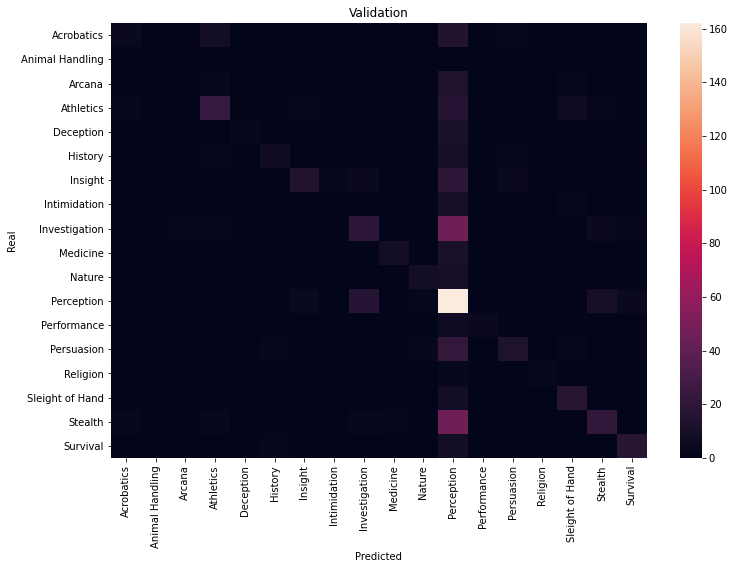

In [100]:
plot_confusion_matrix(lst_skills, 'Validation', y_test, y_pred)

In [101]:
dados_teste['skill'].value_counts()

perception         3898
investigation      1485
stealth            1447
athletics          1037
insight             999
persuasion          935
survival            588
sleight of hand     556
acrobatics          506
nature              499
arcana              484
history             452
deception           449
intimidation        437
medicine            321
performance         213
religion            166
animal handling     144
Name: skill, dtype: int64

Teste sem a skill perception.

In [117]:
dados_teste_2 = dados_teste.loc[dados_teste["skill"] != "perception"]
dados_teste_2

,skill,backward_text,backward_text_clean
0,persuasion,cause the dwarves weren t fans of nobody without any political means of entry however she managed to acquire the necessary documentation and offered you a very substantial reward should you find the whereabouts of lady kima of vord and hopefully bring her back safely you left on the pathway to the dwarven citadel of kraghammer you were ambushed by a group of roaming barbarian goliaths of which partway through the battle grog managed to recognize one of them as a previous ally and no longer an ally at this time son of a bitch yep the barbarian for his first and only time so far managed to avert battle through a social encounter,"[cause, dwarves, weren, fans, means, entry, managed, acquire, documentation, offered, reward, find, whereabouts, lady, kima, vord, bring, left, pathway, citadel, kraghammer, ambushed, group, roaming, goliaths, partway, battle, grog, managed, recognize, ally, ally, time, son, bitch, barbarian, time, managed, avert, battle, encounter]"
1,persuasion,careful sighs not as often as i get woken up from my sleep which is never because only stupid people do that lost cause abandon ship abandon ship right i have an intelligence of six i know what i m doing okay all laugh there is a very pretty lady over there with slightly pointy ears to vex i m talking about you to keyleth or you there s two of them and they were actually wanting to ask you a question if you wouldn t mind,"[sighs, woken, sleep, people, lost, cause, ship, abandon, ship, intelligence, know, laugh, lady, ears, talking, keyleth, wanting, ask, question, wouldn, mind]"
2,persuasion,you re so we just heard you re so impressive and masculine yes we really wanted to talk to you i use my earring of whisper to vex cool it cool it down oh sh okay calm down not so sexy i reach out and i stroke his bicep oh jesus because i can t hear that i use it again i m like what are you doing keyleth stop it i disagree heat it up heat it up,"[heard, wanted, talk, use, earring, whisper, cool, cool, calm, reach, stroke, bicep, jesus, hear, use, keyleth, stop, disagree, heat, heat]"
3,persuasion,they re terrible people anyway my associates and i were wondering if you might come is that what we re doing trying to get him to come with us we re trying to find out more about greyspine yes where he might be or who his associates might be gee i m so glad you came would you like to accompany us on this journey that we re taking oh god we re trying to find the greyspines and you seem like you would want to come in on this we think there might be something rotten in the mines,"[people, associates, wondering, come, trying, come, trying, find, greyspine, associates, came, like, accompany, journey, taking, trying, find, greyspines, want, come, think, mines]"
4,persuasion,anyway my associates and i were wondering if you might come is that what we re doing trying to get him to come with us we re trying to find out more about greyspine yes where he might be or who his associates might be gee i m so glad you came would you like to accompany us on this journey that we re taking oh god we re trying to find the greyspines and you seem like you would want to come in on this we think there might be something rotten in the mines make a persuasion roll you can assist if you like,"[associates, wondering, come, trying, come, trying, find, greyspine, associates, came, like, accompany, journey, taking, trying, find, greyspines, want, come, think, mines, persuasion, roll, assist, like]"
...,...,...,...
14608,investigation,around an hour before sunset the company stealthily come near the bare beech tree grove and the ruins which now you see is an abandoned river side estate s mansion once belonging to some noble from the kingdom it appeared to have been occupied up until the last several years the stones of the surprisingly intact structure not yet overgrown with ivy ooc due to waldeulia and gorbulas both having great successes on stealth odo was al

In [104]:
dados_teste_2['skill'].value_counts()

investigation      1485
stealth            1447
athletics          1037
insight             999
persuasion          935
survival            588
sleight of hand     556
acrobatics          506
nature              499
arcana              484
history             452
deception           449
intimidation        437
medicine            321
performance         213
religion            166
animal handling     144
Name: skill, dtype: int64

In [139]:
def data_leveler(lst_skills, df, min_obs):
    df_sample = pd.DataFrame()

    for skill in lst_skills:
        # Get number of observations for skill
        num_obs = sum(df['skill'].values == dados_teste_2.skill)

        # Make a more homogeneous dataset for training
        if num_obs > min_obs:
            # If skill has more than min_obs, get a sample
            df_skill = df.loc[df['skill'].values == dados_teste_2.skill].sample(n = min_obs).reset_index(drop=True)
        else:
            # If skill has less than min_obs, do an oversample
            df_skill = df.loc[df['skill'].values == dados_teste_2.skill].sample(n = min_obs, replace=True).reset_index(drop=True)

        df_sample = df_sample.append(df_skill).reset_index(drop=True)

    return df_sample
                                                                                                

In [136]:
sum(dados_teste_2['skill'].values == dados_teste_2.skill)

10718

In [134]:
dados_teste_2['skill'].values == dados_teste_2.skill

0        True
1        True
2        True
3        True
4        True
         ... 
14608    True
14609    True
14611    True
14613    True
14615    True
Name: skill, Length: 10718, dtype: bool

In [200]:
sample = data_leveler(skill_list, dados_teste_2, 800)

In [201]:
sample.shape

(13600, 3)

In [202]:
sample_dict = sample['backward_text_clean'].apply(lambda x: ' '.join(x)).tolist()
sample_dict

['sitting stands puts crossbow pointing intent traveling distance speak don mind message ophelia mardun heard charged message business hope impart message message pass tell gentleman south like pass regards',
 'stuie tries way zombie',
 'tremble stepping place influence comfort sarenrae protected understand way deities work lands place sarenrae place know queen know place',
 'looks street water supply fountain outlet fill trough spilling gutter runs waterways trough people wash clothing amdir drops gear jumps trough soaked series moves trait gets dives burning building woman way attempt athletics roll grab escape',
 'inara breathes infects humans makes hurt ends death people seek',
 'shows let laughter johnny says adios starts shimmying pass windows',
 'paces dale putting training use making hunter',
 'weeks perform sister describe performer sir sigh sighs know speak arguing assume individual left performers performers supposed performing coronation brand temple whitestone arranged pai

In [203]:
# # Call NLP pre processing
# clean_text = self.NLP_pp.preprocess(corpus)
# BOW and TFIDF, term must appear at least a number of times, limit max features and use ngrams
tfidf_vec = TfidfVectorizer(analyzer = 'word', max_df = 0.90, min_df = 3, ngram_range=(1, 2))
        
# Build dictionary to be able to use after training
tfidf_vec = tfidf_vec.fit(sample_dict)
        
# Get counts on terms
bow_tfidf = tfidf_vec.transform(sample_dict)

In [204]:
X_train, X_test, y_train, y_test = train_test_split(bow_tfidf, sample['skill'], test_size=0.05, random_state = 42)

In [205]:
%time clf = RandomForestClassifier(n_estimators=200)
%time clf = clf.fit(X_train, y_train)

Wall time: 40 ms
Wall time: 3min 22s


In [206]:
# Teste do treinamento.
y_pred = clf.predict(X_test)

In [207]:
confusion_matrix(y_test, y_pred)

array([[26,  1,  0,  5,  0,  0,  0,  0,  0,  0,  0,  1,  0,  0,  1,  3,
         0],
       [ 0,  6,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0],
       [ 0,  0, 22,  3,  0,  1,  0,  0,  3,  0,  0,  0,  1,  0,  1,  2,
         0],
       [ 1,  1,  0, 51,  0,  0,  1,  0,  1,  0,  1,  0,  0,  0,  2,  3,
         1],
       [ 0,  0,  0,  1, 18,  0,  2,  0,  3,  0,  0,  0,  4,  0,  1,  2,
         0],
       [ 0,  0,  0,  3,  0, 19,  1,  2,  1,  0,  1,  0,  2,  0,  1,  1,
         1],
       [ 1,  0,  0,  3,  0,  1, 58,  0,  4,  0,  0,  0,  3,  0,  0,  2,
         0],
       [ 0,  0,  0,  1,  0,  0,  1, 18,  0,  0,  0,  0,  1,  0,  0,  0,
         0],
       [ 0,  0,  1,  0,  0,  2,  0,  0, 86,  0,  0,  0,  0,  0,  1,  3,
         0],
       [ 0,  0,  0,  1,  0,  0,  0,  0,  0, 12,  0,  0,  0,  0,  0,  0,
         2],
       [ 1,  0,  0,  5,  0,  0,  1,  0,  3,  0, 29,  0,  0,  1,  0,  1,
         0],
       [ 0,  0,  0,  0,  0,  0,  0,  0,  3,  0,  0, 11,  0,  0,  

In [184]:
skill_list = ['acrobatics',
 'animal handling',
 'arcana',
 'athletics',
 'deception',
 'history',
 'insight',
 'intimidation',
 'investigation',
 'medicine',
 'nature',
 'performance',
 'persuasion',
 'religion',
 'sleight of hand',
 'stealth',
 'survival']

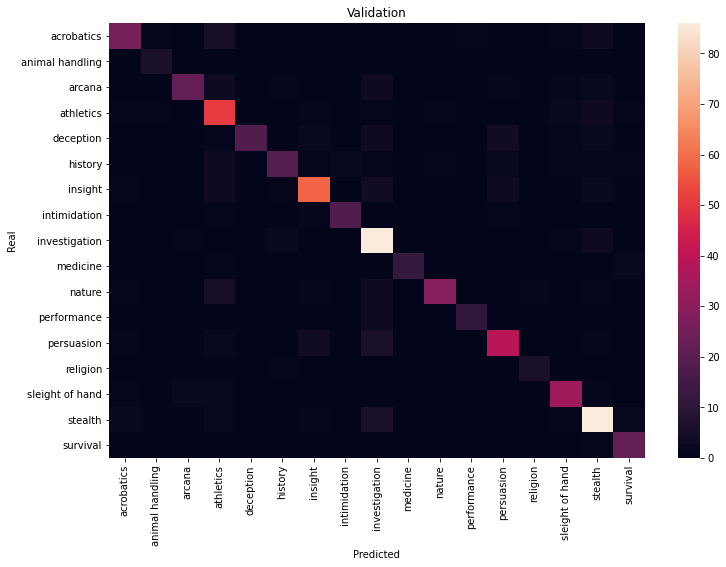

In [208]:
plot_confusion_matrix(skill_list, 'Validation', y_test, y_pred)

In [209]:
sample['skill'].value_counts()

investigation      1898
stealth            1800
athletics          1311
insight            1289
persuasion         1156
survival            722
sleight of hand     721
acrobatics          664
nature              637
arcana              610
deception           592
history             592
intimidation        534
medicine            388
performance         275
religion            226
animal handling     185
Name: skill, dtype: int64